In [4]:
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme

set_nb_theme('chesterish')

In [7]:
#load libraries 
import time,os
from matplotlib.offsetbox import AnchoredText
import sys,pandas as pd, matplotlib , matplotlib.pyplot as plt, matplotlib.lines, numpy as np, math, pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
#import cudf
#import ROOT
#from ROOT import TFile

#import root_pandas

#from toggle_cell import hide_cell 
import uproot3
%matplotlib inline

#presets for plot style
from scipy.constants import golden
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (7, 7/golden),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

viridis = cm.get_cmap('viridis', 12)
inferno = cm.get_cmap('inferno', 12)
autumn = cm.get_cmap('autumn', 12)

#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
#tf.config.experimental.set_memory_growth(physical_devices[1], True)
rc = plt.rc
rc('text', usetex=False)
import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=False)
rc('font', size=15)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

import root_pandas,glob

import gc

import uproot
def read_n(pattern, n):
    if not '*' in pattern:
        a = root_pandas.read_root(pattern,chunksize=int(n))
    else:
        a = root_pandas.read_root(glob.glob(pattern),chunksize=int(n))
    for b in a:
        del a
        print(n)
        return b

from scipy.optimize import curve_fit

image_dir='images'

import misc_util#correlation_plots

import R2h_module 
import imp
imp.reload(R2h_module)

import mplhep as hep
hep.style.use("CMS")

/home/sebouh/.local/lib/python3.8/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/home/sebouh/.local/lib/python3.8/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


In [6]:
#sets =  "D_C C D_Fe Fe Pb D_Pb".split()
#sets += "MC_D2 MC_C MC_Fe MC_Pb".split()
#sets += "no_ecuts_D_C no_ecuts_C no_ecuts_D_Fe no_ecuts_Fe no_ecuts_Pb no_ecuts_D_Pb".split()
#sets += "xQ2_D_C xQ2_C xQ2_D_Fe xQ2_Fe xQ2_Pb xQ2_D_Pb".split()

#dfs_mixed = {a : root_pandas.read_root("../../eg2/python/mixed_%s.root"%a)  for a in sets}

mixtag='xQ2_'
#mixtag='xQ2_originalK_'
dfs_mixed = {a : root_pandas.read_root(f"/data/sebouh/eg2/python/mixed_{mixtag}{a}.root")  for a in "D_C C D_Fe Fe Pb D_Pb".split()}
#dfs_mixed = {a : root_pandas.read_root(f"/home/sebouh/eg2/python/mixed_{mixtag}{a}.root")  for a in "D_C C D_Fe Fe Pb D_Pb".split()}

In [7]:
def getdatainChunks(filename,treename):
    dataframe =pd.DataFrame()
    file = uproot.open(filename) 
    tree=file[treename]
    df=tree.arrays(filter_name='*',library='pd')
    return df

In [19]:
%%time
dfs_pair = {}
dfs_trigger = {}
#path_data="/home/sebouh/di-hadron"
path_data="/home/seba/di-hadron/P27"
for target in ['C','Fe','Pb']:
    print ('Getting dataframes from target %s'%target)
    dfs_pair[target]=getdatainChunks('%s/Pairs_%s.root'%(path_data,target), target)
    dfs_pair['D_%s'%target]= getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 'D_%s'%target)  
    print ('Get trigger dataframes from deuterium target %s'%target)
    dfs_trigger['%s'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
                                                      '%s_trigger'%target)
    dfs_trigger['D_%s'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
                                                        'D_%s_trigger'%target)

Getting dataframes from target C
Get trigger dataframes from deuterium target C
Getting dataframes from target Fe
Get trigger dataframes from deuterium target Fe
Getting dataframes from target Pb
Get trigger dataframes from deuterium target Pb
CPU times: user 4.03 s, sys: 16.8 ms, total: 4.05 s
Wall time: 4.05 s


In [20]:
for dct in dfs_mixed,dfs_pair, dfs_trigger:
    print(dct.keys())
    dct['D'] = pd.concat([dct['D_'+a] for a in 'C Fe Pb'.split()])

dict_keys(['D_C', 'C', 'D_Fe', 'Fe', 'Pb', 'D_Pb', 'D'])
dict_keys(['C', 'D_C', 'Fe', 'D_Fe', 'Pb', 'D_Pb'])


<ipython-input-20-2bd486f10182>:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  dct['D'] = pd.concat([dct['D_'+a] for a in 'C Fe Pb'.split()])


dict_keys(['C', 'D_C', 'Fe', 'D_Fe', 'Pb', 'D_Pb'])


In [21]:
r2h=  R2h_module 
for key in dfs_trigger.keys():
    isMC = False
    if 'GiBUU' in key:
        isMC=True    
    print (key, isMC)
    dfs_trigger[key].rename(columns={'h1_FidCut':'h1_FidCutPiPlus'}, inplace=True)
    dfs_trigger[key] = r2h.applyCuts(dfs_trigger[key],isTrigger=True, isMC=isMC, nomCuts=True)
    print (' ')
    

C False
Entries before cut  652690
Q2>1.0 and Q2<4.0 652690  (100.00  %)
0.2<h1_p<5.0  652674  (100.00  %)
inelasticity < 0.85 652674  (100.00  %)
h1_pid = pions (trigger) 652674  (100.00  %)
2.2 < nu <4.2 642836  (98.49  %)
10< h1_th 642836  (100.00  %)
Theta/P fiducial region selected for trigger hadron 642836  (100.00  %)
Nom cuts for the trigger applied 291788  (45.39  %)
 
D_C False
Entries before cut  875478
Q2>1.0 and Q2<4.0 875478  (100.00  %)
0.2<h1_p<5.0  875467  (100.00  %)
inelasticity < 0.85 875467  (100.00  %)
h1_pid = pions (trigger) 875467  (100.00  %)
2.2 < nu <4.2 863117  (98.59  %)
10< h1_th 863117  (100.00  %)
Theta/P fiducial region selected for trigger hadron 863117  (100.00  %)
Nom cuts for the trigger applied 405810  (47.02  %)
 
Fe False
Entries before cut  370123
Q2>1.0 and Q2<4.0 370122  (100.00  %)
0.2<h1_p<5.0  370122  (100.00  %)
inelasticity < 0.85 370122  (100.00  %)
h1_pid = pions (trigger) 370122  (100.00  %)
2.2 < nu <4.2 370122  (100.00  %)
10< h1_th

In [32]:
%%time
import R2h_module as r2h

for key in dfs_pair.keys():
    isMC = False
    if 'GiBUU' in key:
        isMC=True
    print ('\nkey: ',key)
    dfs_pair[key].rename(columns={'h1_FidCut':'h1_FidCutPiPlus'}, inplace=True)
    dfs_pair[key].rename(columns={'h2_FidCut':'h2_FidCutPiPlus'}, inplace=True)
    dfs_pair[key] = r2h.applyCuts(dfs_pair[key],isMC=isMC, nomCuts=True)
    dfs_pair[key] = r2h.applyCutsPair(dfs_pair[key],isMC=isMC, nomCuts=True)



key:  C
Entries before cut  131591
Q2>1.0 and Q2<4.0 131591  (100.00  %)
0.2<h1_p<5.0  131585  (100.00  %)
inelasticity < 0.85 131585  (100.00  %)
h1_pid = pions (trigger) 131585  (100.00  %)
2.2 < nu <4.2 129258  (98.23  %)
10< h1_th 129258  (100.00  %)
Theta/P fiducial region selected for trigger hadron 129258  (100.00  %)
Nom cuts for the trigger applied 44785  (34.65  %)
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 44785  (100.00  %)
2.2 < nu < 4.2 44785  (100.00  %)
secondary hadrons are pions 44785  (100.00  %)
(h1_pid*h2_pid)<0, opposite charge pions 35717  (79.75  %)
kinematic limits for h2_z 35636  (99.77  %)
kinematic limits for dphi 35596  (99.89  %)
kinematic limits for pair_mass 35415  (99.49  %)
leading hadrons are pions 35415  (100.00  %)
0.2<h2_p<5.0 35415  (100.00  %)
0.2<h1_p<5.0 35415  (100.00  %)
10<h2_th 35415  (100.00  %)
Theta/P fiducial region selected for secondary hadron 32420  (91.54  %)
10< h1_th 32420  (100.00  %)
Theta/P fiducial region

In [22]:
import R2h_module
import imp
imp.reload(R2h_module)
for key in list(dfs_mixed.keys()):
    isMC=False
    if 'GiBUU' in key:
        isMC=True
    dfs_mixed[key].rename(columns={'h1_FidCut':'h1_FidCutPiPlus'}, inplace=True)
    dfs_mixed[key].rename(columns={'h2_FidCut':'h2_FidCutPiPlus'}, inplace=True)
    
    print(f"\n\n{key}")
    if  'dphi' not in dfs_mixed[key].columns:
        dfs_mixed[key].eval('diff_phi_cm = h1_cm_ph-h2_cm_ph', inplace=True)
        dfs_mixed[key].eval(f'diff_phi_cm = diff_phi_cm-{2*np.pi}*(diff_phi_cm>{np.pi})', inplace=True)
        dfs_mixed[key].eval(f'diff_phi_cm = diff_phi_cm+{2*np.pi}*(diff_phi_cm<{-np.pi})', inplace=True)
        dfs_mixed[key].eval(f'dphi = abs(diff_phi_cm)', inplace=True)
    dfs_mixed[key].eval('h1_e=nu*h1_z',inplace=True)
    dfs_mixed[key].eval('h2_e=nu*h2_z',inplace=True)
    dfs_mixed[key].eval(f'drap=0.5*log((h1_e+sqrt(h1_p**2-h1_cm_pt**2))/(h1_e-sqrt(h1_p**2-h1_cm_pt**2)))-0.5*log((h2_e+sqrt(h2_p**2-h2_cm_pt**2))/(h2_e-sqrt(h2_p**2-h2_cm_pt**2)))',inplace=True)

    mixed_trigger_cuts = dfs_mixed[key]#R2h_module.applyCuts(dfs_mixed[key])    
    dfs_mixed[key] = R2h_module.applyCutsPair(mixed_trigger_cuts,isMC=isMC,
                                                             nomCuts=True,h2Proton=False, minPt=np.sqrt(0.005))
    
    #for df in (dfs_data[key + '_2pi'],dfs_data[key + '_pi_p']):
    #    df.eval('diff_rap_cm=0.5*log((h1_e+sqrt(h1_p**2-h1_cm_pt**2))/(h1_e-sqrt(h1_p**2-h1_cm_pt**2)))-0.5*log((h2_e+sqrt(h2_p**2-h2_cm_pt**2))/(h2_e-sqrt(h2_p**2-h2_cm_pt**2)))',inplace=True)
    #    df.eval('diff_phi_cm = h1_cm_ph-h2_cm_ph', inplace=True)
    #    df.eval(f'diff_phi_cm = diff_phi_cm-{2*np.pi}*(diff_phi_cm>{np.pi})', inplace=True)
    #    df.eval(f'diff_phi_cm = diff_phi_cm+{2*np.pi}*(diff_phi_cm<{-np.pi})', inplace=True)



D_C
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 339912  (100.00  %)
2.2 < nu < 4.2 339912  (100.00  %)
secondary hadrons are pions 339912  (100.00  %)
(h1_pid*h2_pid)<0, opposite charge pions 339912  (100.00  %)
kinematic limits for h2_z 339912  (100.00  %)
kinematic limits for dphi 339912  (100.00  %)
kinematic limits for pair_mass 339912  (100.00  %)
leading hadrons are pions 339912  (100.00  %)
0.2<h2_p<5.0 339912  (100.00  %)
0.2<h1_p<5.0 339912  (100.00  %)
pt>0.07071067811865475 GeV 339912  (100.00  %)
10<h2_th 339912  (100.00  %)
Theta/P fiducial region selected for secondary hadron 339912  (100.00  %)
10< h1_th 339912  (100.00  %)
Theta/P fiducial region selected for trigger hadron 339912  (100.00  %)
Nom cuts for the pair applied (pi pi) 339912  (100.00  %)


C
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 226338  (100.00  %)
2.2 < nu < 4.2 226338  (100.00  %)
secondary hadrons are pions 226338  (100.00  %)
(h1_pid*h2_pid)<0, opposite ch

In [23]:
#dfs_mc= {f"{a}_2pi":root_pandas.read_root(f"/home/sebouh/CreatePairTuples/MC_Pairs_weighted_{a}.root",a) for a in "C Fe Pb".split()}
#dfs_mc["D_2pi"] = root_pandas.read_root(f"/home/sebouh/CreatePairTuples/MC_Pairs_weighted_C.root","D_C")

In [24]:
# additional cuts that were not applied to the GiBUU set in PRL,
# but we should see what happens if we include them.  
pThetaCuts_trig=' ((h1_pid==211 and h1_th>10) or (h1_pid==-211) and ((h1_th>25 and h1_p>0.7) or (h1_p>0.5 & h1_th>30) or (h1_th>40)))'

#pThetaCuts_trig+=" and h1_th>20 and h1_p<2.7"

pThetaCuts_pair=pThetaCuts_trig 
pThetaCuts_pair += " and " + pThetaCuts_trig.replace("h1_", "h2_").replace("h2_th", "h2_th*180/3.1415926535")



In [42]:
def get_values(slicevar='drap', slicevartex='\Delta Y', slicebins=(-1,0,1,2,3), 
               dropLeadPiMinus=True, usePRLcuts=False, saveFig=False,
              pThetaCutsGiBUU=True, pMin=.350, pT1min=.25, pT2min=.25,
               suptitle=None,nbins_data=8, nbins_GiBUU=16, GiBUU_suffix="",
              addCuts=None, addCutsTrig=None):
    #unbinned.
    if slicevar is None:
        slicebins=[0,1]
    
    pids = [211, -211]
    
    data=[]
    GiBUU=[]
    sliceinfo={}
    
    #guess for the systematic errors from sources not inves
    systPct=3
    pid=211
    
    for k in range(len(slicebins)-1):
        data.append({})
        GiBUU.append({})
        slice_range=slicebins[k:k+2]

        integral_data_D = 0
        data_D=None
        stat_D=None
        if usePRLcuts: #use separate calculation for D data gained with each
                       #nuclear target, just like in the PRL
            Alist= zip((0, -1, 1,-1,2, -1,3), "D D_C C D_Fe Fe D_Pb Pb".split())
        else:
            Alist = enumerate("D C Fe Pb".split())
        for i, A in Alist:

            

            q = f"h1_pid=={pid}  and h2_z>0.05 and h2_z<0.45 and h1_cm_pt > {pT1min} and "+\
                 f"h2_cm_pt > {pT2min} and h1_z>0.5 and h2_pid=={-pid} and h2_p>{pMin}"
            #q += " and h1_p<2.7"
            #q+= " and h1_p<2.7 and h2_p>0.5 and h1_cm_pt>0.3 and h2_cm_pt>0.3"
            if usePRLcuts:
                #the dtheta_epi1 cut is a useless one, but we used it in the PRL paper,
                #so we need this in order to make the comparison
                q = "dtheta_epi1>25 and h2_z>0.05 and h2_z<0.45 and " + PRL_trigger_cut_nom + PRL_pair_cut_nom 

            if slicevar != None:
                q+= f" and {slicevar}>={slice_range[0]} and {slicevar}<{slice_range[1]}"
            
            if addCuts is not None:
                q+= f" and {addCuts}"

            which_set = "D_Pb" if A=="D" and usePRLcuts else A
            #which_set=A

            bins = np.linspace(0,np.pi if not usePRLcuts else 3.14,nbins_data+1)

            N2, x = np.histogram(dfs_pair[which_set].query(q)['dphi'], bins=bins)
            if usePRLcuts:
                q = "h2_z>0.05 and h1_z>0.5"
            N2mix, x = np.histogram(dfs_mixed["D" if usePRLcuts else A].query(q)['dphi'], bins=bins)

            M_alt = mix_corr_alt(dfs_mixed[A].query(q))
            
            qtrig = f"h1_pid=={pid} and  h1_cm_pt > {pT1min}"
            if usePRLcuts:
                qtrig = "dtheta_epi1>25 and " + PRL_trigger_cut_nom

            if addCutsTrig is not None:
                qtrig += f" and {addCutsTrig}"
            
            N1 = len(dfs_trigger[which_set].query(qtrig))

            x = (x[1:]+x[:-1])/2
            dx = x[1]-x[0]

            S = N2/dx/N1/2
            dSstat = np.sqrt(N2*(N1-N2)/N1**3)/dx/2

            M = N2mix/(sum(N2mix)/len(N2mix))
            dMstat = np.sqrt(N2mix)/(sum(N2mix)/len(N2mix))

            M_err = np.sqrt(np.mean((M-1)**2))/2
            #print((A,pid,k),"estimated syst error from event mixing",  M_err)

            C = S/M
            dCstat = dSstat/M
            
            


            if A=="D" or "D_" in A:  
                integral_data_D=sum(C)*dx*2

            dCsyst = np.hypot(C*systPct/100, C*dMstat)
            C/=integral_data_D
            dCstat/=integral_data_D
            dCsyst/=integral_data_D

            if A=='D' or "D_" in A:
                data_D=C
                stat_D=dCstat

            R_data = C/data_D
            dR_data_stat = C/data_D*np.hypot(dCstat/C, stat_D/data_D)
            dCtot = np.hypot(dCstat, dCsyst)

            
            data[k][A] = pd.DataFrame(dict(C=C, dCstat=dCstat, dCsyst=dCsyst, 
                                            phi=x,phi_low=bins[:-1], phi_up=bins[1:],
                                                S=S, M=M, dSstat=dSstat, dMstat=dMstat,
                                                R=R_data,
                                                dRstat=dR_data_stat, M_alt=M_alt))
            if "D_" in A:
                continue

            #GiBUU
            # do the GiBUU twice: once with the same number of bins as the data,
            # and then with a finer binning
        
#         for useFinerBinning in False, True:
#             integral_GiBUU_D = 0
#             GiBUU_D=None
#             for i, A in enumerate("D C Fe Pb".split()):
            
#                 nbins = nbins_data if not useFinerBinning else nbins_GiBUU
#                 bins = np.linspace(0,np.pi if not usePRLcuts else 3.14,nbins+1)
#                 q = f"h1_pid=={pid} and h1_z>0.5  and h2_z>0.05 and h2_z<0.45 and h1_cm_pt > {pT1min} and h2_cm_pt > {pT2min} and h2_pid=={-pid}"
#                 if usePRLcuts:
#                     q = "h2_z>0.05 and h1_z>0.5 and h2_z<0.45"
#                 if slicevar != None:
#                     q+= f" and {slicevar}>={slice_range[0]} and {slicevar}<{slice_range[1]}"
#                 if pThetaCutsGiBUU:
#                     q += " and " + pThetaCuts_pair + f" and h2_p>{pMin}"


#                 N2, x = np.histogram(dfs_pair[f"GiBUU_{A}"+GiBUU_suffix].query(q)['dphi'], bins=bins)

#                 x = (x[1:]+x[:-1])/2
#                 dx =x[1]-x[0]

#                 qtrig = f"h1_pid=={pid}  and h1_z>0.5 "
#                 if usePRLcuts:
#                     qtrig = "h1_pid==h1_pid"
#                 if pThetaCutsGiBUU:
#                     qtrig += " and " + pThetaCuts_trig + f" and  h1_cm_pt > {pT1min}"
#                 N1 = len(dfs_trigger["GiBUU_"+A+GiBUU_suffix].query(qtrig))
#                 y = N2/N1/dx/2
#                 #print(N1, N2)
#                 if A=="D":
#                     integral_GiBUU_D=sum(y)*dx*2

#                 y/=integral_GiBUU_D

#                 if A=="D" or "D_" in A:
#                     GiBUU_D = pd.Series(y)
#                 R_GiBUU = y/GiBUU_D

#                 tmp = A + "_fine" if useFinerBinning else A
#                 GiBUU[k][tmp] = pd.DataFrame(dict(C=y, R=y/GiBUU_D,
#                                                 phi=x, 
#                                                  phi_low=bins[:-1], phi_up=bins[1:]))
            
            

        if slicevar is not None:
            sliceinfo[k] = f"{slice_range[0]:.2f} < ${slicevartex}$< {slice_range[1]:.2f}"
        else :
            sliceinfo[k] = f""
                
    return data, GiBUU, sliceinfo

In [43]:
import copy
def apply_endcap_corrections(data):
    yD = data['D']['C']
    dyD = data['D']['dCstat']
    yC = data['C']['C']
    dyC = data['C']['dCstat']
    yFe = data['Fe']['C']
    dyFe = data['Fe']['dCstat']

    dx =  data['Fe']['phi'][1]-data['Fe']['phi'][0]
    
    # fraction of the events in the deuterium set that are actually from the endcaps
    # determined from Taisiya's note
    fAl=(len(dfs_pair['D_C'])*3.15+len(dfs_pair['D_Fe'])*2.37+len(dfs_pair['D_Fe'])*2.27)\
        /((len(dfs_pair['D_C'])+len(dfs_pair['D_Fe'])+len(dfs_pair['D_Fe']))*100)

    
    #yC*=sum(yD)/sum(yC)
    #yFe*=sum(yD)/sum(yFe)
    
    # use corrections assuming C(Al) is halfway between C(C) and C(Fe)
    yAl = (yC+yFe)/2
    
    # normalize this to the deuterium 
    #yAl *= sum(yD)/sum(yAl)
    
    # uncertainty from the stat uncertainty on the Al interpolation, 
    # and also from the interpolation itself
    dyAl = np.sqrt(1/(1/dyC**2+1/dyFe**2)+(yC-yFe)**2)/2
    yDcorr = (yD-fAl*yAl)
    dyDcorr= fAl*dyAl
    
    newIntegral =2*dx*sum(yDcorr)
    dyDcorr/=newIntegral
    yDcorr/=newIntegral 
    
    data_corr = copy.deepcopy(data)
    data_corr['D']['C']=yDcorr
    data_corr['D']['dCsyst']=np.hypot(data_corr['D']['dCsyst'], dyDcorr)
    
    data_corr['D']['dCsyst_EC'] = dyDcorr
    data_corr['D']['C_correction_EC'] = yDcorr-yD
    
    data_corr['C']['C']/=newIntegral
    data_corr['Fe']['C']/=newIntegral
    data_corr['Pb']['C']/=newIntegral
    
    return data_corr

In [44]:
import pickle

with open('syst_from_misid.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    syst_from_misid = pickle.load(f)
def add_syst_error_from_misid(data, key):
    for i in range(len(data)):
        for A in "D C Fe Pb".split():
            data[i][A]['dCsyst_pid']=syst_from_misid[key][i]*data[i][A].C
            data[i][A].dCsyst =  np.hypot(data[i][A].dCsyst,data[i][A]['dCsyst_pid'])

In [45]:
all_data_uncorr={}
all_data={}
all_GiBUU={}
all_sliceinfo={}

In [46]:
#tighter cut on CC
p_thr=2.5
#Nphe_thr=15
Nphe_thr=5
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)

CC_alt_cut=f"{Nphe_h1_cut} and {Chi2CC_h1_cut} and {StatCC_h1_cut}"

In [47]:
for df in dfs_mixed.values():
    df.eval('TargTypeSM=1.5', inplace=True)

In [50]:
def get_widths(dfs):
    ret = []
    for i in range(len(dfs)):
        widths={}
        for k in range(4):
            A = "D C Fe Pb".split()[k]
            df = dfs[i][A]
                
            y = df.C
            dystat = df.dCstat
            dytot= np.hypot(df.dCstat, df.dCsyst)
            phi=df.phi
            #print(y, dy, phi)
            binwidth=(-phi[:-1]+phi[1:])
            #width=np.sqrt(sum(y*((phi-np.pi)**2-binwidth**2/12))/sum(y))
            width=np.sqrt(sum(y*((phi-np.pi)**2))/sum(y))
            widths[A]=width
        ret.append(widths)
    return ret
def get_broadenings(widths):
    #print(len(widths))
    ret = []
    for i in range(len(widths)):
        #print(widths[i])
        broadenings={}
        for k in range(3):
            A = "C Fe Pb".split()[k]
            broadenings[A]=np.sqrt(widths[i][A]**2-widths[i]["D"]**2)
        ret.append(broadenings)
    return ret

In [51]:
d={}
#varname = "variation name"
for varname, cut in [("nominal",{}),
                     ("vtx_alt", dict(addCuts="TargTypeSM>0",
                                           addCutsTrig="TargTypeSM>0")),
                     ("p2_gt_370",dict(addCuts="h2_p>.37")),
                    ("pt_gt_27", dict(addCuts="h2_cm_pt>.27 and h1_cm_pt>.27", 
                                      addCutsTrig="h1_cm_pt>.27")),
                    ("vtx_dZ_lt_2pt7", dict(addCuts="abs(h1_deltaZ)<2.7 and abs(h2_deltaZ)<2.7",
                                           addCutsTrig="abs(h1_deltaZ)<2.7")),
                    
                    ("CC_thresh_2pt5", dict(addCuts=CC_alt_cut, addCutsTrig=CC_alt_cut)),
                     
                    ]:

    d[(varname,"all")], _, _ = get_values(None,GiBUU_suffix='_tweak2', **cut)
    d[(varname, "dY")], _, _ = get_values("drap", "\Delta Y", (0, 0.5, 1,1.5, 2.0),GiBUU_suffix='_tweak2', **cut)
    d[(varname, "pT1")], _, _ = get_values("h1_cm_pt", "p^T_{1}", (0.25, 0.4, 0.6, 1),
                                    GiBUU_suffix='_tweak2', **cut)
    d[(varname, "pT2")], _, _ = get_values("h2_cm_pt", "p^T_{2}", (0.25, 0.4,0.6, 0.8),
                                    GiBUU_suffix='_tweak2', **cut)
    
    for key in "all", "dY", "pT1", "pT2":
        d[(varname,key, "width")] = get_widths(d[(varname,key)])
        d[(varname,key, "broadening")] = get_broadenings(d[(varname,key, "width")])

In [52]:
cut_syst_table={}
all_bins=[]
for key in "all", "dY", "pT1", "pT2":
    cut_syst_table[key] =[]
    for i in range(len(d[("nominal", key)])):
        sumsq=0
        dct={}
        for varname in ("p2_gt_370","pt_gt_27", "vtx_dZ_lt_2pt7",
                       "CC_thresh_2pt5"):
            sumdiffs=0
            N=0
            for a in "D C Fe Pb".split():
                diff = d[(varname, key)][i][a].C/d[("nominal", key)][i][a].C-1
                sumdiffs+=diff
                N+=1
            avgdiff=sumdiffs/N
            dct[varname]=avgdiff
            sumsq+=avgdiff**2
        dct["tot"]=np.sqrt(sumsq/len(dct))
        all_bins+=list(dct["tot"])
        print(key, i, dct['tot'])
        cut_syst_table[key].append(pd.DataFrame(dct))
print("median", pd.Series(all_bins).median())
print("max", pd.Series(all_bins).max())
import pickle
with open("syst_from_cuts.pkl", "wb") as f:
    pickle.dump(cut_syst_table, f, pickle.HIGHEST_PROTOCOL)

all 0 0    0.049774
1    0.044852
2    0.034920
3    0.024987
4    0.018594
5    0.009670
6    0.010615
7    0.018542
Name: C, dtype: float64
dY 0 0    0.037182
1    0.081814
2    0.072081
3    0.033459
4    0.028697
5    0.008854
6    0.017867
7    0.025631
Name: C, dtype: float64
dY 1 0    0.056552
1    0.031950
2    0.025686
3    0.022804
4    0.021342
5    0.013136
6    0.003871
7    0.013800
Name: C, dtype: float64
dY 2 0    0.045227
1    0.055560
2    0.028616
3    0.022644
4    0.023060
5    0.006712
6    0.008790
7    0.016777
Name: C, dtype: float64
dY 3 0    0.053706
1    0.036216
2    0.046774
3    0.036073
4    0.016299
5    0.011702
6    0.020230
7    0.025347
Name: C, dtype: float64
pT1 0 0    0.054989
1    0.045361
2    0.042143
3    0.021381
4    0.008022
5    0.008579
6    0.014999
7    0.024914
Name: C, dtype: float64
pT1 1 0    0.031764
1    0.040839
2    0.016935
3    0.018059
4    0.016791
5    0.011188
6    0.005517
7    0.014058
Name: C, dtype: float64
pT1 2 0   

In [53]:
cut_syst_table_widths={}
for key in "all", "dY", "pT1", "pT2":
    cut_syst_table_widths[key] =[]
    for i in range(len(d[("nominal", key)])):
        sumsq=0
        dct={}
        for varname in ("p2_gt_370","pt_gt_27", "vtx_dZ_lt_2pt7",
                       "CC_thresh_2pt5"):
            sumdiffs=0
            N=0
            for a in "D C Fe Pb".split():
                diff = d[(varname, key, "width")][i][a]/d[("nominal", key, "width")][i][a]-1
                sumdiffs+=diff
                N+=1
            avgdiff=sumdiffs/N
            dct[varname]=avgdiff
            sumsq+=avgdiff**2
        dct["tot"]=np.sqrt(sumsq/len(dct))
        print(key, i, dct['tot'], dct['tot']*d[(varname, key, "width")][i][a])
        cut_syst_table_widths[key].append(dct)

with open("syst_from_cuts_widths.pkl", "wb") as f:
    pickle.dump(cut_syst_table_widths, f, pickle.HIGHEST_PROTOCOL)

all 0 0.013060535684879061 0.017198282530826673
dY 0 0.017843174724648303 0.02118459550633454
dY 1 0.01030347534694322 0.012987078444733135
dY 2 0.012378885439800117 0.01640263769310354
dY 3 0.01538222317334511 0.022654240581134365
pT1 0 0.014248396391862284 0.0220138868897643
pT1 1 0.008303810745755135 0.010760273894778504
pT1 2 0.008754473876513203 0.009727922445437081
pT2 0 0.015801907334050708 0.023145163449301044
pT2 1 0.00634966319231387 0.007687855566728748
pT2 2 0.00428410205691346 0.004149401885866856


In [54]:
cut_syst_table_broadenings={}
for key in "all", "dY", "pT1", "pT2":
    cut_syst_table_broadenings[key] =[]
    for i in range(len(d[("nominal", key)])):
        sumsq=0
        dct={}
        for varname in ("p2_gt_370","pt_gt_27", "vtx_dZ_lt_2pt7",
                       "CC_thresh_2pt5"):
            sumdiffs=0
            N=0
            for a in "C Fe Pb".split():
                diff = d[(varname, key, "broadening")][i][a]/d[("nominal", key, "broadening")][i][a]-1
                sumdiffs+=diff
                N+=1
            avgdiff=sumdiffs/N
            dct[varname]=avgdiff
            sumsq+=avgdiff**2
        dct["tot"]=np.sqrt(sumsq/len(dct))
        print(key, i, dct['tot'])
        cut_syst_table_broadenings[key].append(dct)
with open("syst_from_cuts_broadenings.pkl", "wb") as f:
    pickle.dump(cut_syst_table_broadenings, f, pickle.HIGHEST_PROTOCOL)

all 0 0.006890004219588428
dY 0 0.013183602551220195
dY 1 0.006032789580601774
dY 2 0.008689789722520668
dY 3 0.010826300862739155
pT1 0 0.016420688588394378
pT1 1 0.007128235465988102
pT1 2 0.005880746961000834
pT2 0 0.014973926088391182
pT2 1 0.0030578002514600263
pT2 2 0.008196122848863653


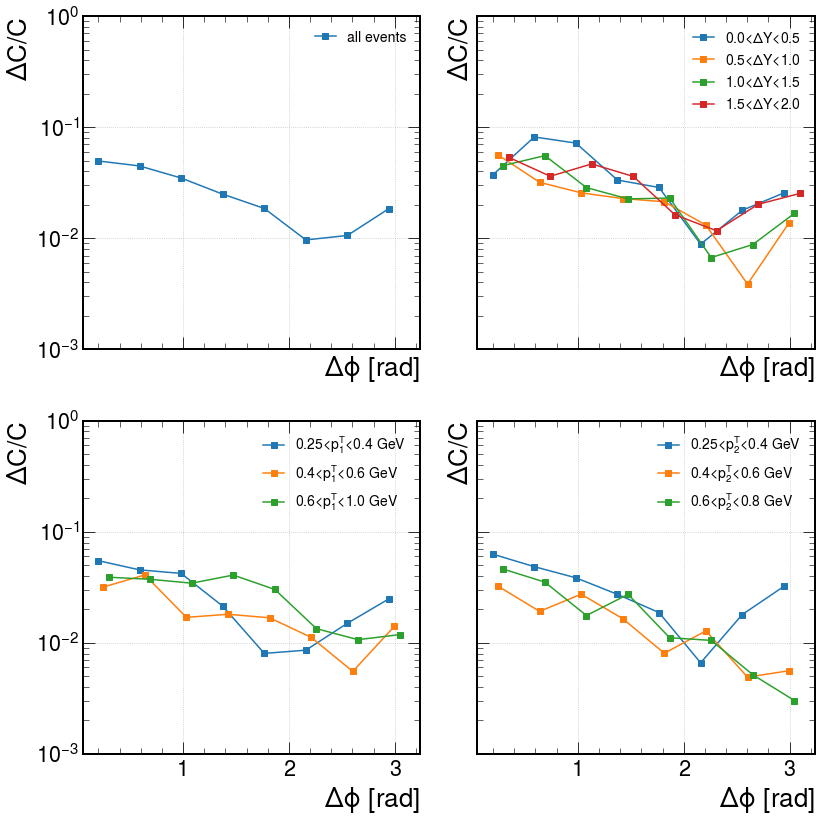

In [16]:
import pickle
#help(pickle)
with open("syst_from_cuts.pkl", "rb") as f:
    cut_syst_table=pickle.load(f)
    
#print(cut_syst_table)
keys = "all dY pT1 pT2".split()

j = 0
fig, axs=plt.subplots(2,2, figsize=(12, 12), sharex = True, sharey=True)


labels = "all events;0.0<$\Delta Y$<0.5;0.5<$\Delta Y$<1.0;1.0<$\Delta Y$<1.5;1.5<$\Delta Y$<2.0;"
labels+= "0.25<$p^T_1$<0.4 GeV;0.4<$p^T_1$<0.6 GeV;0.6<$p^T_1$<1.0 GeV;"
labels+= "0.25<$p^T_2$<0.4 GeV;0.4<$p^T_2$<0.6 GeV;0.6<$p^T_2$<0.8 GeV"
labels= labels.split(";")

shift=0

k=0
for i, label in enumerate(labels):
    plt.sca(axs[j//2][j%2])
      
    #n=n+0.5*(n==0)
    x= np.linspace(0, np.pi, 9)
    x= (x[1:]+x[:-1])/2+shift
    y=cut_syst_table[keys[j]][k].tot
    plt.errorbar(x, y, label=label, marker='s')
    
    if i in (0, 4, 7, 10):
        plt.xlabel("$\Delta\phi$ [rad]")
        plt.ylabel("$\Delta C/C$")
        plt.legend(fontsize=14)
        plt.yscale('log')
        plt.grid()
        plt.ylim(1e-3, 1)
        shift=0
        j+=1
        k=0
    else:
        shift +=0.05
        k+=1
plt.tight_layout()
plt.show()